# Image Generation with Generative Adverserial

## Imports

In [0]:
%tensorflow_version 2.x
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
import time
from datetime import timedelta
import imageio
import PIL

from IPython import display

TensorFlow 2.x selected.


## Load the Dataset

We have used the MNIST Handwritten digits dataset.

In [0]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

## Preprocessing

In this pahse we have only rehaped the input data and normalized it.

In [0]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

## Use *tf.data* to create batches and shuffle the dataset

In [0]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [0]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Models

Here is the class that holds the models and also provides some of the basic functionalities associated to saving and loading the models.

In [0]:
class DCGAN(tf.keras.Model):
  def __init__(self, noise_dim):
    super(DCGAN, self).__init__()
    self.noise_dim = noise_dim
    self.generator = tf.keras.Sequential(
      [
        tf.keras.layers.Dense(7*7*256, use_bias=False, input_shape=(self.noise_dim,)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Reshape((7, 7, 256)),
        tf.keras.layers.Conv2DTranspose(128, (5, 5), padding='same', use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Conv2DTranspose(64, (5, 5), (2, 2), padding='same', use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Conv2DTranspose(1, (5, 5), (2, 2), padding='same', use_bias=False, activation=tf.nn.tanh),
      ], name='Generator'
    )

    self.discriminator = tf.keras.Sequential(
      [
        tf.keras.layers.Conv2D(64, (5, 5), (2, 2), input_shape=(28, 28, 1), padding='same'),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Conv2D(128, (5, 5), (2, 2), padding='same'),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1),
      ], name='Discriminator'
    )

  def save(self, fname=None):
    if fname:
      self.discriminator.save_weights(f'{fname}-discriminator-weights.h5')
      self.generator.save_weights(f'{fname}-generator-weights.h5')
    else:
      self.discriminator.save_weights('dcgan-discriminator-weights.h5')
      self.generator.save_weights('dcgan-generator-weights.h5')
  
  def load(self, fname=None):
    if fname:
      self.discriminator.load_weights(f'{fname}-discriminator-weights.h5')
      self.generator.load_weights(f'{fname}-generator-weights.h5')
    else:
      self.discriminator.load_weights('dcgan-discriminator-weights.h5')
      self.generator.load_weights('dcgan-generator-weights.h5')

## Loss Functions and Optimizers

In [0]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

## Parameters for training and the CVAE Object

### Parameters:

- *EPOCHS*: Number of epochs for training
- *noise_dim*: Dimentionality of the Noice Input
- *num_examples_to_generate*: Number of samples to be generated during the training and testing process
- *seed*: for Sample Image Generation during Training
- *model*: DCGAN Model object

In [0]:
EPOCHS = 500
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
model = DCGAN(noise_dim)

### Model Sumaries

In [0]:
model.generator.summary()

Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0 

In [0]:
model.discriminator.summary()

Model: "Discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)            

### Function to Generate and SaveImages

In [0]:
def generate_and_save_images(model, epoch, test_input, save_img=False, folder='images'):
  if not os.path.exists(folder):
    os.mkdir(folder)
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(8, 8))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  if save_img:
    plt.savefig(f'{folder}/{folder}_{epoch:04d}.png')
  plt.show()

## Train Block

In [0]:
@tf.function
def train_step(model, images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = model.generator(noise, training=True)

      real_output = model.discriminator(images, training=True)
      fake_output = model.discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, model.generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, model.discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, model.generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, model.discriminator.trainable_variables))

    return gen_loss, disc_loss

In [0]:
def train(dataset, epochs):
  generate_and_save_images(model.generator, 0, seed, save_img=True)
  
  gen_losses = []
  disc_losses = []
  start_training = time.perf_counter()

  for epoch in range(1, epochs + 1):
    gen_loss = tf.keras.metrics.Mean()
    disc_loss = tf.keras.metrics.Mean()

    start = time.perf_counter()
    for image_batch in dataset:
      gl, dl = train_step(model, image_batch)
      gen_loss(gl)
      disc_loss(dl)
    elapsed = time.perf_counter() - start

    gen_losses.append(gen_loss.result())
    disc_losses.append(disc_loss.result())

    display.clear_output(wait=True)
    print (f'ETA: {timedelta(seconds=int(elapsed * (epochs - epoch)))}\tEpoch: {epoch}/{epochs}\tGenerator Loss: {gen_losses[-1]:.4f}\tDiscriminator Loss: {disc_losses[-1]:.4f}')
    generate_and_save_images(model.generator, epoch, seed, epoch % 5 == 0)

  training_time = time.perf_counter() - start_training

  return gen_losses, disc_losses, training_time

ETA: 0:00:00	Epoch: 500/500	Generator Loss: 0.8930	Discriminator Loss: 1.2648


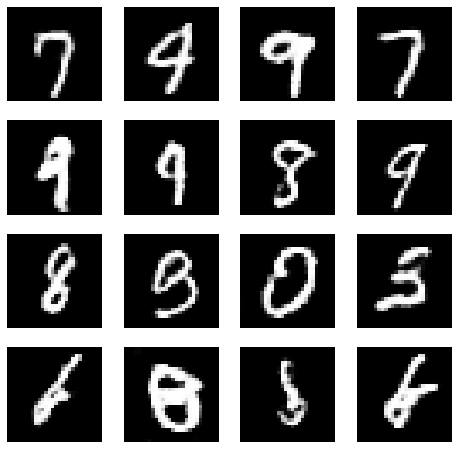

In [0]:
gen_losses, disc_losses, training_time = train(train_dataset, EPOCHS)

In [0]:
print(f'Training Time: {timedelta(seconds=int(training_time))}')

Training Time: 1:52:23


## Losses

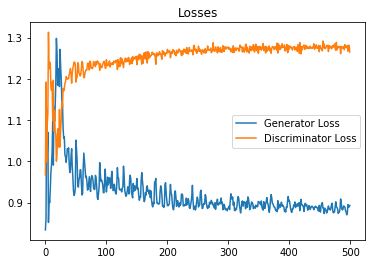

In [0]:
plt.plot(list(range(len(gen_losses))), gen_losses, label='Generator Loss')
plt.plot(list(range(len(disc_losses))), disc_losses, label='Discriminator Loss')
plt.title('Losses')
plt.legend()

plt.savefig('dcgan-losses.png')
plt.show()

## Samples

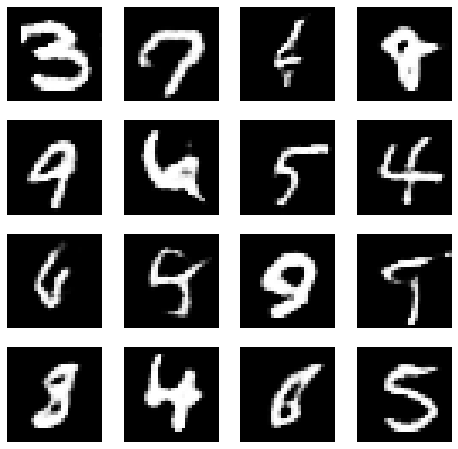

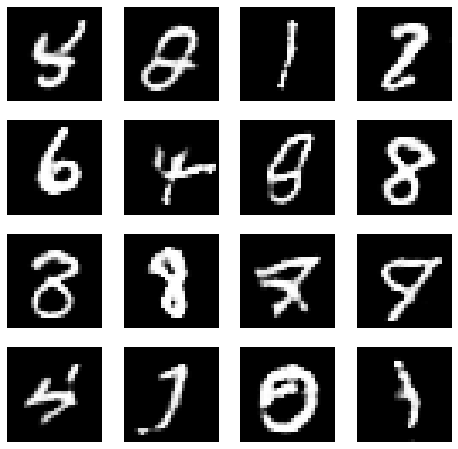

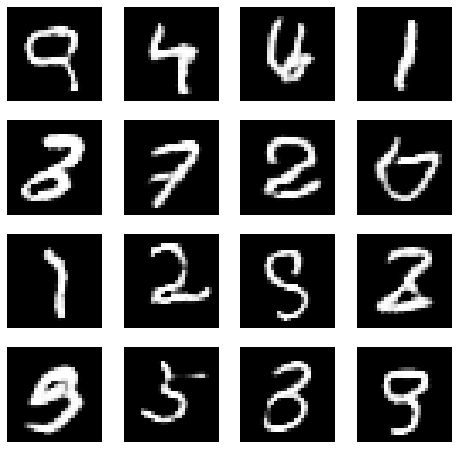

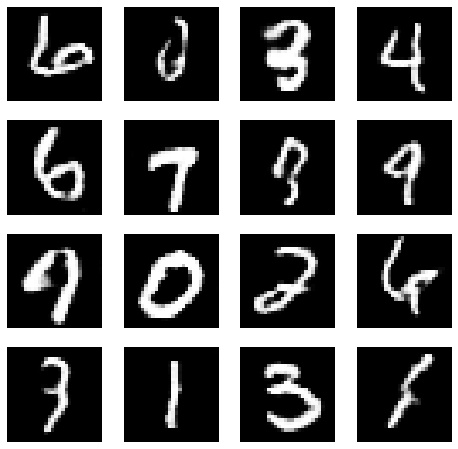

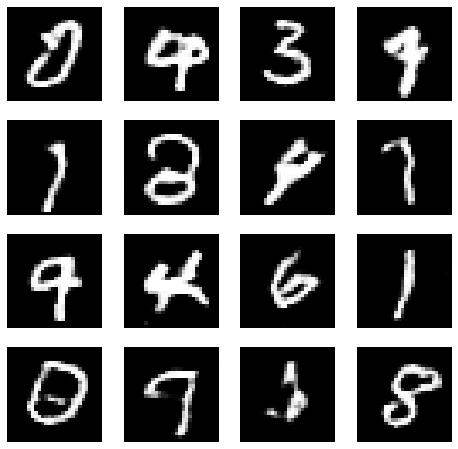

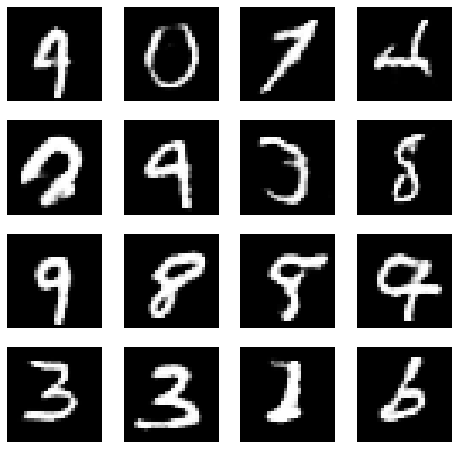

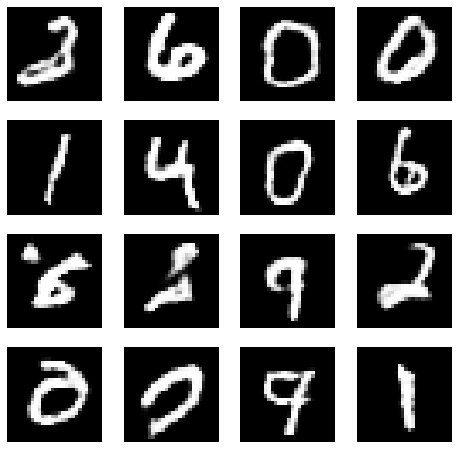

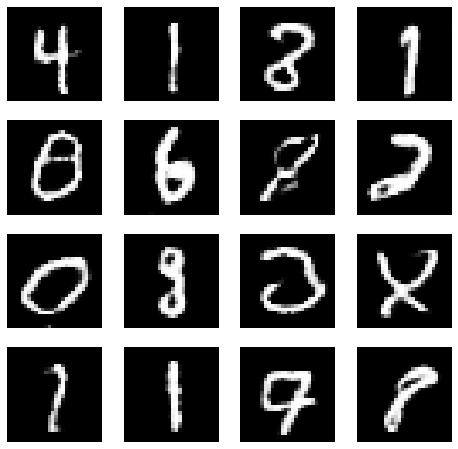

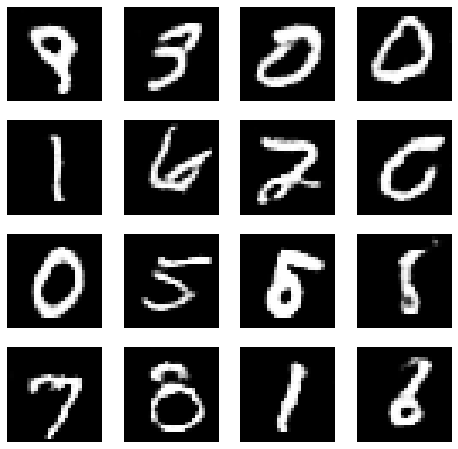

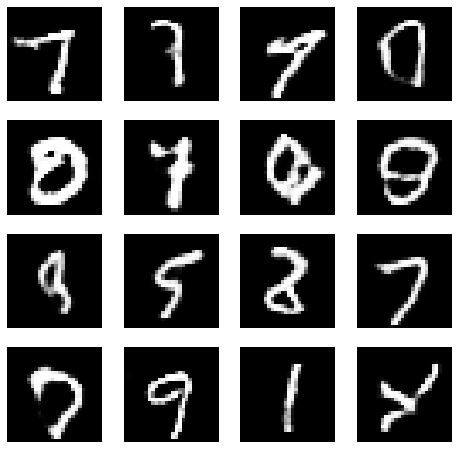

In [0]:
for j in range(10):
  sample_seed = tf.random.normal([num_examples_to_generate, noise_dim])
  generate_and_save_images(model.generator, j, sample_seed, save_img=True, folder='samples')

## Predictions by the Benchark Model

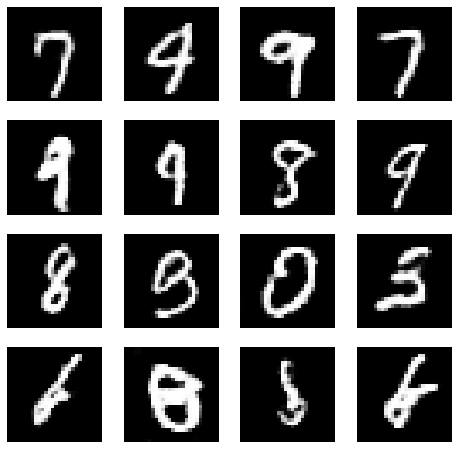

Predictions for above generated imagrs:
 [[7 4 9 7]
 [9 9 8 9]
 [8 3 0 5]
 [6 8 8 8]]


In [0]:
# seed = tf.random.normal(shape=[16, 100])
samples = (model.generator.predict(seed) + 1) / 2

benchmark_model = tf.keras.models.load_model('mnist-benchmark.h5')
predictions = benchmark_model.predict_classes(samples)

fig = plt.figure(figsize=(8, 8))

for i in range(samples.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(samples[i, :, :, 0] * 255, cmap='gray')
    plt.axis('off')

plt.show()
print('Predictions for above generated imagrs:\n', predictions.reshape((4, 4)))